In [1]:
import numpy as np
import numpy
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from time import time
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
import tensorflow as tf
# tf.enable_eager_execution()

In [3]:
sys.path.append('../code/utils/')
sys.path.append('../code/flowpm/')
import tools
from background import *
import tfpm 
import tfpmfuncs as tfpf
from tfpmconfig import Config


# PM

In [4]:
pkfile = '../code/flowpm/Planck15_a1p00.txt'
config = Config(bs=400, nc=128, seed=100, pkfile=pkfile)
bs, nc = config['boxsize'], config['nc']
grid = bs/nc*np.indices((nc, nc, nc)).reshape(3, -1).T.astype(np.float32)


In [5]:
# tf.reset_default_graph()

# linear = tfpm.linfield(config)
# lineark = tfpf.r2c3d(linear, config)
# icstate = tfpm.lptinit(lineark, grid, config)
# final = tf.zeros_like(linear)
# final = tfpf.cic_paint(final, icstate[0], boxsize=bs)

# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     linmesh, finmesh, fstate = sess.run([linear, final, icstate])


In [6]:
tf.reset_default_graph()

linear = tfpm.linfield(config)
lineark = tfpf.r2c3d(linear, config)
icstate = tfpm.lptinit(lineark, grid, config)
fnstate = tfpm.nbody(icstate, config, verbose=True)
final = tf.zeros_like(linear)
final = tfpf.cic_paint(final, fnstate[0], boxsize=bs)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    linmesh, finmesh, fstate = sess.run([linear, final, fnstate])


F 0.1 0.1 0.1
K 0.1 0.1 0.18027756377319948
D 0.1 0.18027756377319948 0.325
F 0.1 0.325 0.325
K 0.18027756377319948 0.325 0.325
K 0.325 0.325 0.4227883631321941
D 0.325 0.4227883631321941 0.55
F 0.325 0.55 0.55
K 0.4227883631321941 0.55 0.55
K 0.55 0.55 0.6528782428600298
D 0.55 0.6528782428600298 0.775
F 0.55 0.775 0.775
K 0.6528782428600298 0.775 0.775
K 0.775 0.775 0.8803408430829505
D 0.775 0.8803408430829505 1.0
F 0.775 1.0 1.0
K 0.8803408430829505 1.0 1.0


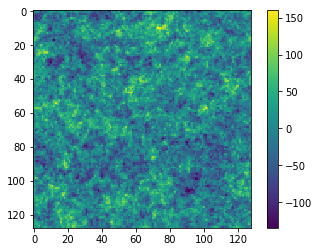

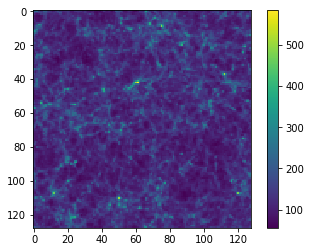

In [11]:
im = plt.imshow(linmesh.sum(axis=0))
plt.colorbar(im)
plt.show()
im = plt.imshow(finmesh.sum(axis=0))
plt.colorbar(im)
plt.show()


# Reconstruction

### Generate Data

In [7]:
#Generate DATA

pkfile = '../code/flowpm/Planck15_a1p00.txt'
config = Config(bs=100, nc=32, seed=100, pkfile=pkfile)
bs, nc = config['boxsize'], config['nc']
grid = bs/nc*np.indices((nc, nc, nc)).reshape(3, -1).T.astype(np.float32)


tf.reset_default_graph()

linear = tfpm.linfield(config)
lineark = tfpf.r2c3d(linear, config)
icstate = tfpm.lptinit(lineark, grid, config)
fnstate = tfpm.nbody(icstate, config, verbose=True)
final = tf.zeros_like(linear)
final = tfpf.cic_paint(final, fnstate[0], boxsize=bs)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    truth, data = sess.run([linear, final])


F 0.1 0.1 0.1
K 0.1 0.1 0.18027756377319948
D 0.1 0.18027756377319948 0.325
F 0.1 0.325 0.325
K 0.18027756377319948 0.325 0.325
K 0.325 0.325 0.4227883631321941
D 0.325 0.4227883631321941 0.55
F 0.325 0.55 0.55
K 0.4227883631321941 0.55 0.55
K 0.55 0.55 0.6528782428600298
D 0.55 0.6528782428600298 0.775
F 0.55 0.775 0.775
K 0.6528782428600298 0.775 0.775
K 0.775 0.775 0.8803408430829505
D 0.775 0.8803408430829505 1.0
F 0.775 1.0 1.0
K 0.8803408430829505 1.0 1.0


In [8]:
#Generate DATA

tf.reset_default_graph()

linear = tfpm.linfield(config)
lineark = tfpf.r2c3d(linear, config)
icstate = tfpm.lptinit(lineark, grid, config)
fnstate = tfpm.nbody(icstate, config, verbose=True)
final = tf.zeros_like(linear)
final = tfpf.cic_paint(final, fnstate[0], boxsize=bs)
gradient = tf.gradients(final, linear)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    truth, data, grad = sess.run([linear, final, gradient])


F 0.1 0.1 0.1
K 0.1 0.1 0.18027756377319948
D 0.1 0.18027756377319948 0.325
F 0.1 0.325 0.325
K 0.18027756377319948 0.325 0.325
K 0.325 0.325 0.4227883631321941
D 0.325 0.4227883631321941 0.55
F 0.325 0.55 0.55
K 0.4227883631321941 0.55 0.55
K 0.55 0.55 0.6528782428600298
D 0.55 0.6528782428600298 0.775
F 0.55 0.775 0.775
K 0.6528782428600298 0.775 0.775
K 0.775 0.775 0.8803408430829505
D 0.775 0.8803408430829505 1.0
F 0.775 1.0 1.0
K 0.8803408430829505 1.0 1.0


In [9]:
# grad

## Try recon

In [ ]:
tf.reset_default_graph()

kmesh = sum(kk**2 for kk in config['kvec'])**0.5
priorwt = config['ipklin'](kmesh)
# priorwt

linear = tf.get_variable('linmesh', shape=(nc, nc, nc), initializer=tf.random_normal_initializer(), trainable=True)
lineark = tfpf.r2c3d(linear, config)
icstate = tfpm.lptinit(lineark, grid, config)
fnstate = tfpm.nbody(icstate, config, verbose=False)
final = tf.zeros_like(linear)
final = tfpf.cic_paint(final, fnstate[0], boxsize=bs)
#
priormesh = tf.multiply(lineark, priorwt)
prior = tf.norm(priormesh)
prior = tf.cast(prior, tf.float32)
# prior = tf.multiply(prior, 1/nc**3)

difference = tf.subtract(final, data)
sigma = 0.1
difference = tf.multiply(difference, 1/sigma)
chisq = tf.multiply(difference, difference)

Rsm = tf.placeholder(tf.float32, name='smoothing')
Rsm = tf.multiply(Rsm, bs/nc)
Rsmsq = tf.multiply(Rsm, Rsm)
smwts = tf.exp(tf.multiply(-0.5*kmesh**2, Rsmsq))
chisqc = tfpf.r2c3d(chisq, config)
chisqc = tf.multiply(chisqc, tf.cast(smwts, tf.complex64))
chisq = tfpf.c2r3d(chisqc, config)
chisq = tf.norm(chisq)

#chisq = tf.losses.mean_squared_error(final, data, weights=1/0.1)
loss = tf.add(chisq, prior)
# grad = tf.gradients(loss, linear)
# # prior = tf.losses.mean_squared_error(final, 0, weights=)


# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     l = sess.run(grad)


lr = tf.placeholder(tf.float32, name='learningrate')
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
opt_op = optimizer.minimize(loss, var_list=[linear])
# opt_op = optimizer.minimize(loss)

niter = 5000
lr0 = 100
nlr, lrfac = 2000, 2
nprint = 1000
R0 = 4.

with tf.Session() as sess:
    losses = []
    sess.run(tf.global_variables_initializer())
    l, init = sess.run([loss, linear], {Rsm:0.})
    losses.append(l)
    #
    start, curr = time(), time()
    
    for it in range(niter+1):
#         print(it)
        _, l = sess.run([opt_op, loss], feed_dict={lr:lr0, Rsm:R0})
        if it % nlr == 0:
            lr0 /= lrfac
            R0 /= 2
            print('reduce learning rate by factor of %0.2f. New learning rate = %0.2e'%(lrfac, lr0))
        if it % nprint == 0:
            end = time()
            print('Iter %d of %d : Loss= %0.4f\nTime taken for last batch = %0.3f, \
            \nTotal time elapsed = %0.3f'%(it, niter, l, end-curr, end - start))
            curr = end


        losses.append(l)

    recon = sess.run(linear)


reduce learning rate by factor of 2.00. New learning rate = 5.00e+01
Iter 0 of 5000 : Loss= 164280.9688
Time taken for last batch = 0.625,             
Total time elapsed = 0.625


In [ ]:
plt.plot(losses)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (13, 4))
im = ax[0].imshow(truth.sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('Truth')
im = ax[1].imshow(init.sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Init')
im = ax[2].imshow(recon.sum(axis=0))
plt.colorbar(im, ax=ax[2])
ax[2].set_title('Recon')


In [ ]:
im = plt.imshow((recon-truth).sum(axis=0))
plt.colorbar(im)

In [ ]:
im = plt.imshow((init-truth).sum(axis=0))
plt.colorbar(im)

In [60]:
recon.mean()

-0.012947775

In [63]:
k, pt = tools.power(1+truth, boxsize=bs)
k, pi = tools.power(1+init, boxsize=bs)
k, pr = tools.power(1+recon, boxsize=bs)
k, px = tools.power(1+truth, 1+recon, boxsize=bs)

[]

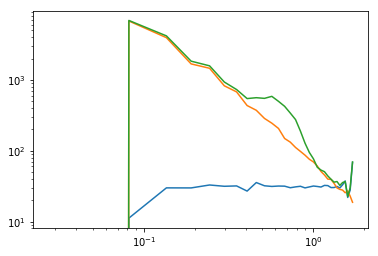

In [64]:
plt.plot(k, pi)
plt.plot(k, pt)
plt.plot(k, pr)
plt.loglog()

/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/chmodi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


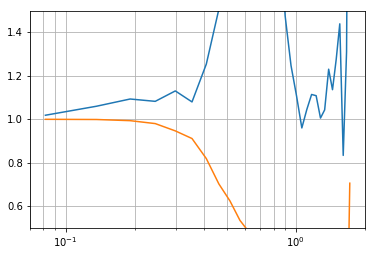

In [69]:
plt.plot(k, pr/pt)
plt.plot(k, px/(pr*pt)**.5)
plt.xscale('log')
plt.ylim(0.5, 1.5)
plt.grid(which='both')